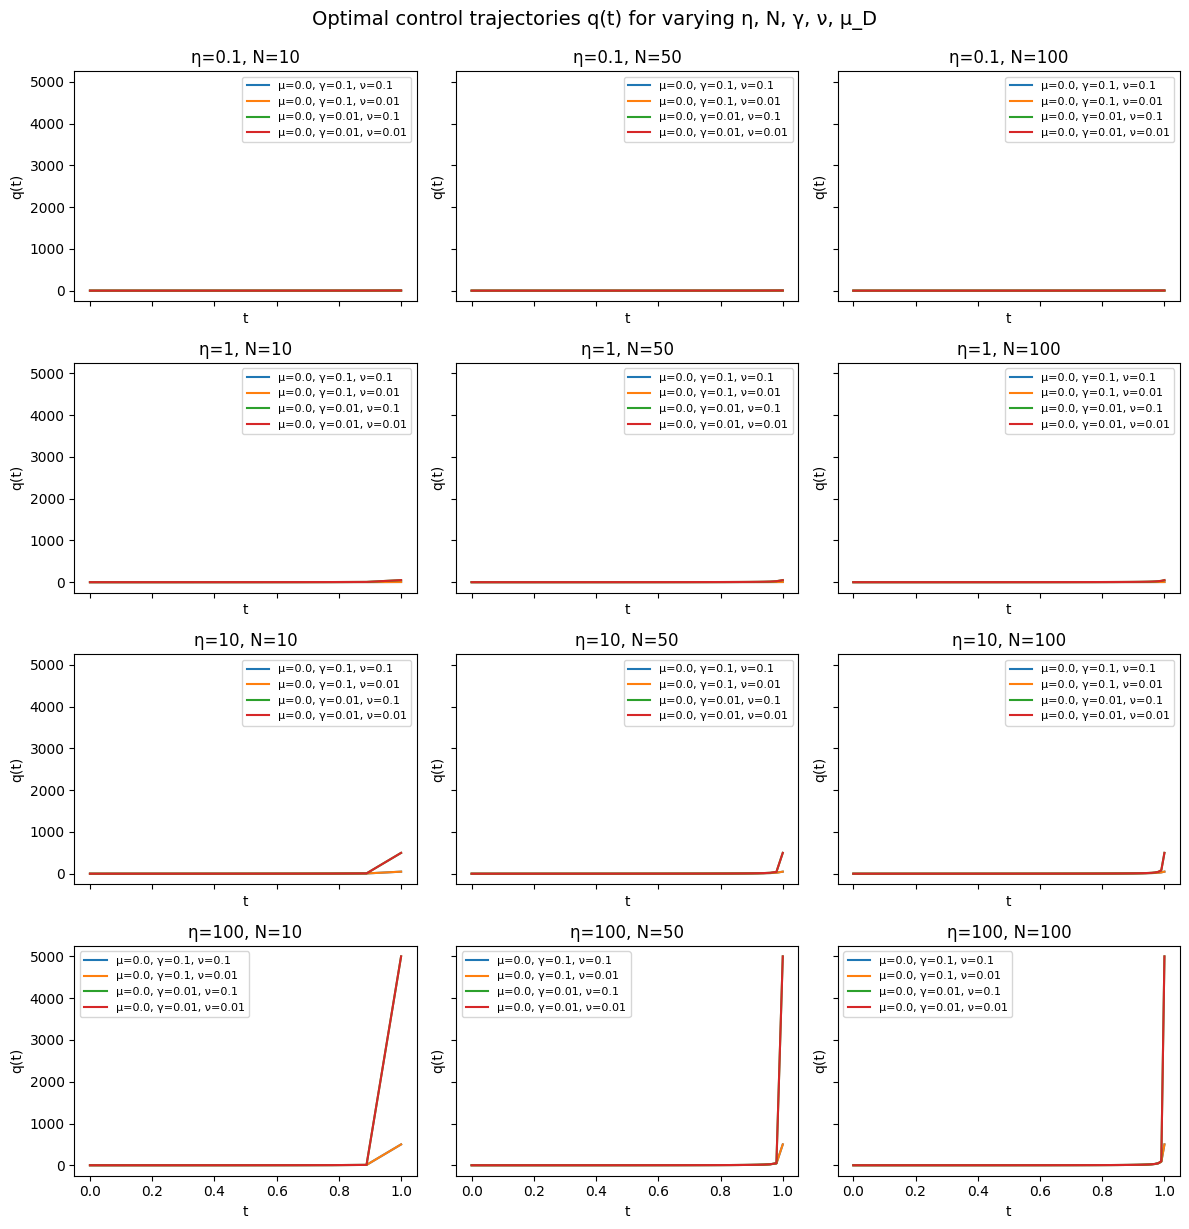

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the optimal control formula as a function
def optimal_control(t, X, P, D, T, eta, gamma, nu, mu_D):
    tau = T - t
    numerator = eta * (mu_D * tau + D - X) - P
    denominator = (eta + nu) * tau + 2 * gamma
    return numerator / denominator

# Parameters
T = 1.0
X = 0.0
P = 0.0
D = 1.0

etas = [0.1, 1, 10, 100]
gammas = [0.1, 0.01]
nus = [0.1, 0.01]
mu_Ds = [0.0, 0.1]

# Discretizations
Ns = [10, 50, 100]
results = {}

# Simulate
for mu_D in mu_Ds:
    for gamma in gammas:
        for nu in nus:
            key = f"mu={mu_D}, gamma={gamma}, nu={nu}"
            results[key] = {}
            for eta in etas:
                for N in Ns:
                    t_grid = torch.linspace(0, T, N)
                    q_vals = optimal_control(t_grid, X, P, D, T, eta, gamma, nu, mu_D)
                    results[key][(eta, N)] = (t_grid.numpy(), q_vals.detach().numpy())

# Plotting
import matplotlib.pyplot as plt
import math
from itertools import product
from matplotlib.ticker import MaxNLocator

ncols = len(Ns)
nrows = len(etas)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True)

for (mu_D, gamma, nu), ax_row in zip(product(mu_Ds, gammas, nus), axes.reshape(-1, len(Ns))):
    for i, eta in enumerate(etas):
        for j, N in enumerate(Ns):
            t, q = results[f"mu={mu_D}, gamma={gamma}, nu={nu}"][(eta, N)]
            ax = axes[etas.index(eta), Ns.index(N)]
            ax.plot(t, q, label=f"μ={mu_D}, γ={gamma}, ν={nu}")
            ax.set_title(f"η={eta}, N={N}")
            ax.set_xlabel("t")
            ax.set_ylabel("q(t)")
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle("Optimal control trajectories q(t) for varying η, N, γ, ν, μ_D", y=1.02, fontsize=14)
plt.show()


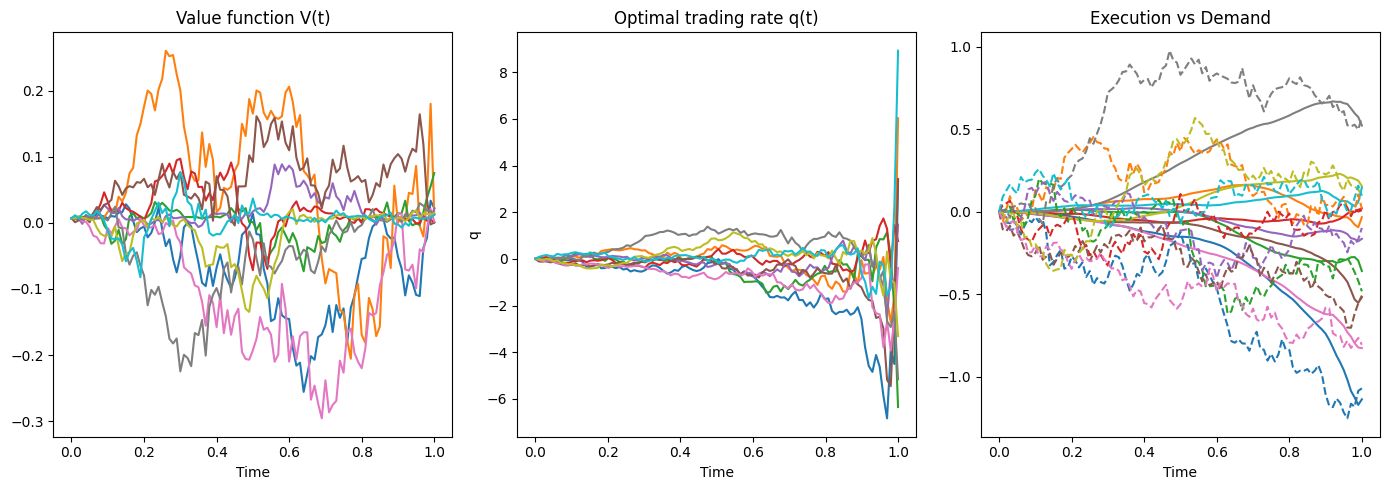

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1.0
N = 100
dt = T / N
M = 1000  # number of trajectories

# Model parameters
mu_D = 0
mu_P = 0
sigma_D = 0.5
sigma_P = 0.5
rho = 0.01
gamma = 0.01
nu = 0.01
eta = 10.0

# Initial conditions
X0, P0, D0 = 0.0, 0.0, 0.0

# Precompute Brownian increments
W1 = np.random.randn(M, N) * np.sqrt(dt)
W2 = np.random.randn(M, N) * np.sqrt(dt)

# Initialize paths
X = np.zeros((M, N+1))
P = np.zeros((M, N+1))
D = np.zeros((M, N+1))
q = np.zeros((M, N))
V = np.zeros((M, N+1))

X[:, 0] = X0
P[:, 0] = P0
D[:, 0] = D0

def optimal_control(t, x, p, d):
    tau = T - t
    return (eta * (mu_D * tau + d - x) - p) / ((eta + nu) * tau + 2 * gamma)

def value_function(t, x, p, d):
    tau = T - t
    denom = (eta + nu) * tau + 2 * gamma
    A = eta * (0.5 * nu * tau + gamma) / denom
    B = -0.5 * tau / denom
    F = eta * tau / denom
    G = 2 * mu_D * tau * A
    H = -2 * eta * mu_D * tau * B
    log_term = gamma * (sigma_P**2 + sigma_D**2 * eta**2 - 2 * rho * sigma_P * sigma_D * eta) / (eta + nu)**2
    log_expr = 1 + ((eta + nu) * tau) / (2 * gamma)
    K1 = log_term * np.log(log_expr)
    K2 = (sigma_D**2 * eta * nu + 2 * rho * sigma_P * sigma_D * eta - sigma_P**2) / (2 * (eta + nu)) * tau
    K3 = eta * mu_D**2 * tau**2 * (0.5 * nu * tau + gamma) / denom
    K = K1 + K2 + K3
    z = d - x
    return A * z**2 + B * p**2 + F * z * p + G * z + H * p + K

# Simulate forward
for n in range(N):
    t = n * dt
    q[:, n] = optimal_control(t, X[:, n], P[:, n], D[:, n])
    X[:, n+1] = X[:, n] + q[:, n] * dt
    P[:, n+1] = P[:, n] + (mu_P + nu * q[:, n]) * dt + sigma_P * W1[:, n]
    D[:, n+1] = D[:, n] + mu_D * dt + sigma_D * (rho * W1[:, n] + np.sqrt(1 - rho**2) * W2[:, n])
    V[:, n] = value_function(t, X[:, n], P[:, n], D[:, n])

# Final value
V[:, -1] = value_function(T, X[:, -1], P[:, -1], D[:, -1])

# Plot results
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(np.linspace(0, T, N+1), V[:10].T)
plt.title("Value function V(t)")
plt.xlabel("Time")

plt.subplot(1, 3, 2)
plt.plot(np.linspace(0, T, N), q[:10].T)
plt.title("Optimal trading rate q(t)")
plt.xlabel("Time")
plt.ylabel("q")

plt.subplot(1, 3, 3)
plt.plot(np.linspace(0, T, N+1), X[:10].T)
plt.plot(np.linspace(0, T, N+1), D[:10].T, '--')
plt.title("Execution vs Demand")
plt.xlabel("Time")

plt.tight_layout()
plt.show()


C:\Users\alexl\AppData\Local\Temp\ipykernel_15168\2801594857.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", 10)


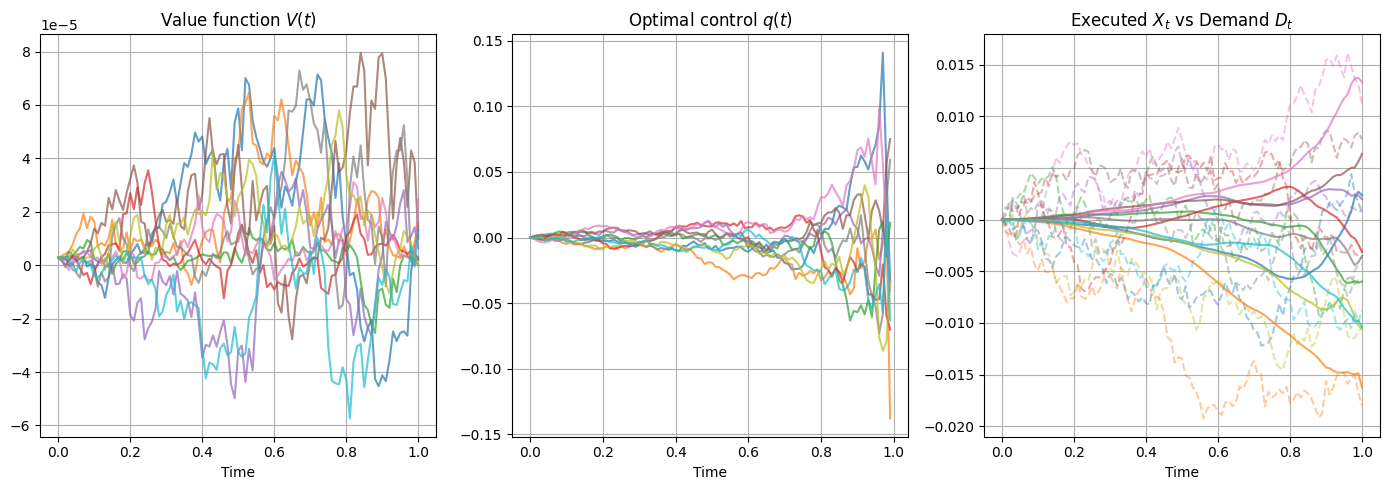

In [104]:
# Re-import required libraries after kernel reset
import torch
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
T = 1.0
N = 100
dt = T / N
n_paths = 100

# Model parameters
params = {
    "mu_D": 0,
    "mu_P": 0,
    "sigma_D": 0.01,
    "sigma_P": 0.01,
    "rho": 0.01,
    "gamma": 0.01,
    "nu": 0.01,
    "eta": 10.0
}

# Initialize tensors
device = torch.device("cpu")
times = torch.linspace(0, T, N + 1).to(device)
y = torch.zeros(N + 1, n_paths, 3, device=device)  # [X, P, D]
q = torch.zeros(N, n_paths, device=device)
V = torch.zeros(N + 1, n_paths, device=device)

# Initial state
y[0, :, :] = 0.0

# Brownian increments
W1 = torch.randn(N, n_paths, device=device) * dt**0.5
W2 = torch.randn(N, n_paths, device=device) * dt**0.5

def optimal_control_analytic(t, y):
    X = y[:, 0:1]
    P = y[:, 1:2]
    D = y[:, 2:3]
    tau = T - t
    return ((params["eta"] * (params["mu_D"] * tau + D - X)) - P) / ((params["eta"] + params["nu"]) * tau + 2 * params["gamma"])

def value_function_analytic(t, y):
    X = y[:, 0:1]
    P = y[:, 1:2]
    D = y[:, 2:3]

    tau = T - t
    denom = (params["eta"] + params["nu"]) * tau + 2 * params["gamma"]

    A = params["eta"] * (0.5 * params["nu"] * tau + params["gamma"]) / denom
    B = -0.5 * tau / denom
    F = params["eta"] * tau / denom
    G = 2 * params["mu_D"] * tau * A
    H = -2 * params["eta"] * params["mu_D"] * tau * B

    log_term = params["gamma"] * (params["sigma_P"]**2 + params["sigma_D"]**2 * params["eta"]**2 -
                                  2 * params["rho"] * params["sigma_P"] * params["sigma_D"] * params["eta"]) / (params["eta"] + params["nu"])**2
    log_expr = 1 + ((params["eta"] + params["nu"]) * tau) / (2 * params["gamma"])
    K1 = log_term * torch.log(log_expr)

    K2 = (params["sigma_D"]**2 * params["eta"] * params["nu"] +
          2 * params["rho"] * params["sigma_P"] * params["sigma_D"] * params["eta"] - params["sigma_P"]**2) / (2 * (params["eta"] + params["nu"])) * tau
    K3 = params["eta"] * params["mu_D"]**2 * tau**2 * (0.5 * params["nu"] * tau + params["gamma"]) / denom
    K = K1 + K2 + K3

    z = D - X
    return (A * z**2 + B * P**2 + F * z * P + G * z + H * P + K).squeeze(1)

# Simulate using analytical control
for n in range(N):
    t = times[n]
    y_n = y[n]
    q[n] = optimal_control_analytic(t, y_n).squeeze(1)
    dX = q[n] * dt
    dP = (params["mu_P"] + params["nu"] * q[n]) * dt + params["sigma_P"] * W1[n]
    dD = params["mu_D"] * dt + params["sigma_D"] * (params["rho"] * W1[n] + (1 - params["rho"]**2)**0.5 * W2[n])
    y[n + 1, :, 0] = y[n, :, 0] + dX
    y[n + 1, :, 1] = y[n, :, 1] + dP
    y[n + 1, :, 2] = y[n, :, 2] + dD
    V[n] = value_function_analytic(t, y[n])

V[-1] = 0.5 * params["eta"] * (y[-1, :, 2] - y[-1, :, 0])**2

# Plot results
import matplotlib.cm as cm
colors = cm.get_cmap("tab10", 10)
timesteps = times.cpu().numpy()

plt.figure(figsize=(14, 5))

for i in range(10):
    plt.subplot(1, 3, 1)
    plt.plot(timesteps, V[:, i].cpu(), color=colors(i), alpha=0.7)
plt.title("Value function $V(t)$")
plt.xlabel("Time")
plt.grid()

for i in range(10):
    plt.subplot(1, 3, 2)
    plt.plot(timesteps[:-1], q[:, i].cpu(), color=colors(i), alpha=0.7)
plt.title("Optimal control $q(t)$")
plt.xlabel("Time")
plt.grid()

for i in range(10):
    plt.subplot(1, 3, 3)
    plt.plot(timesteps, y[:, i, 0].cpu(), label=f"$X_{i}(t)$", color=colors(i), alpha=0.7)
    plt.plot(timesteps, y[:, i, 2].cpu(), '--', label=f"$D_{i}(t)$", color=colors(i), alpha=0.4)
plt.title("Executed $X_t$ vs Demand $D_t$")
plt.xlabel("Time")
plt.grid()

plt.tight_layout()
plt.show()
